In [ ]:
from utils import *

NOTEBOOK_ID = '10'
RUN_MODELS = False

/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0


In [2]:
# input_df = pd.read_pickle('../../04-OTHER/organize/02-misc/06-df.pkl')
input_df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl')
activity = input_df['activity'].to_numpy()
ACTIVITY_THRESHOLD = 80_000
y_bin = (activity >= ACTIVITY_THRESHOLD).astype(np.int64).reshape(-1, 1)
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)

X = np.asarray([np.array(emb) for emb in input_df[f'esm2_t33_650M_UR50D']])
train, val, test, idx = get_stratified_split(X, y_bin, y_cont, as_tensor=True)

(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
(train_idx, val_idx, test_idx) = idx

# select tiles from Hummel

In [ ]:
query_df = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/top_models.csv')
df_filtered = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/model_testing_filtered.csv').set_index('file')

out_file = f'{HAMMING_ENSEMBLE_DIR}/03-results/ensemble_niklas_test.pkl'
if not os.path.isfile(out_file):
    predictions, uncertainty = get_uncertainty(X_test)
    test_df = input_df.loc[test_idx].copy().reset_index(drop=True).rename(columns={'Activity_500k_Rat':'activity'})
    test_df['prediction'] = predictions
    print(pearsonr(test_df['activity'],test_df['prediction'])[0])
    test_df['uncertainty'] = uncertainty
    test_df.to_pickle(out_file)
else:
    test_df = pd.read_pickle(out_file)
    test_df['activity_scaled'] = scaler.transform(test_df['activity'].to_numpy().reshape(-1,1)).flatten()
    test_df['prediction_scaled'] = scaler.transform(test_df['prediction'].to_numpy().reshape(-1,1)).flatten()

In [4]:
_, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 20)
hits_df = df_filtered.reset_index()
hits_df = hits_df.loc[selected_indices].set_index('file')
query_df[query_df.file.isin(hits_df.index)].to_csv(f'{HAMMING_ENSEMBLE_DIR}/ADhunter_v2_ensemble_params_n20.csv',index=False)

In [5]:
out_file = f'{LIBRARY_DIR}/hummel_test.csv'
if not os.path.isfile(out_file):
    test_df['diff'] = abs(test_df['activity'] - test_df['prediction'])
    test_df['category'] = pd.cut(test_df['prediction'],600)
    categories = test_df['category'].unique()
    top_entries_list = []
    for category in tqdm(categories):
        top_entries = test_df[test_df['category'] == category].nsmallest(1, 'diff')
        top_entries_list.append(top_entries)
    top_entries_df = pd.concat(top_entries_list).reset_index(drop=True)
    print(len(top_entries_df))
    test_df['activity'] = scaler.fit_transform(test_df['activity'].to_numpy().reshape(-1,1))
    test_df['prediction'] = scaler.fit_transform(test_df['prediction'].to_numpy().reshape(-1,1))
    top_entries_df['activity'] = scaler.fit_transform(top_entries_df['activity'].to_numpy().reshape(-1,1))
    top_entries_df['prediction'] = scaler.fit_transform(top_entries_df['prediction'].to_numpy().reshape(-1,1))
    top_entries_df.to_csv(out_file,index=False)
else:
    top_entries_df = pd.read_csv(out_file)


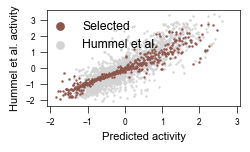

In [6]:
plt.figure(figsize=(2.5,1.25))
g = sns.scatterplot(test_df,x='prediction_scaled',y='activity_scaled',alpha=1,s=3,label='Hummel et al.',color='lightgrey',linewidth=0)
sns.scatterplot(top_entries_df,x='prediction',y='activity',s=3,label='Selected',color=COLORS[10],linewidth=0)#color='#d89b47'
g.set(xlabel='Predicted activity',ylabel='Hummel et al. activity')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False)

for lh in g.legend_.legend_handles: 
    lh.set_alpha(1)
    lh._sizes = [40]
g.set_xlim(-2.1,3.1)

g.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
g.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
sns.move_legend(g,'upper left',bbox_to_anchor=(-0.05, 1.0))
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hummel_selected.png',**FIGURE_PARAMS)
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hummel_selected.svg',transparent=True,bbox_inches='tight')

# select tiles from mycocosm

In [7]:
if not os.path.isfile(f'{LIBRARY_DIR}/mycocosm_test.csv'):
    mycocosm_df = pd.read_csv(f'{MYCOCOSM_DIR}/clustered_90/output_combined.csv')
    mycocosm_df['category'] = pd.cut(mycocosm_df['predictions'],10_500)
    categories = mycocosm_df['category'].unique()
    print(len(categories))
    top_entries_list = []
    for category in tqdm(categories):
        top_entries = mycocosm_df[mycocosm_df['category'] == category].nlargest(1, 'uncertainty')
        top_entries_list.append(top_entries)
    top_entries_df = pd.concat(top_entries_list).reset_index(drop=True)
    seqs = {}
    subfiles = natsorted(glob(f'{MYCOCOSM_DIR}/clustered_90/tmp/*.fasta'), alg=ns.IGNORECASE)
    for subfile in tqdm(subfiles):
        fasta_sequences = SeqIO.parse(open(subfile),'fasta')
        for fasta in fasta_sequences:
            seqs[fasta.name] = str(fasta.seq)
    top_entries_df['seq'] = top_entries_df['tile_id'].apply(lambda x: seqs[x])
    top_entries_df.to_csv(f'{LIBRARY_DIR}/mycocosm_test.csv',index=False)
else:
    top_entries_df = pd.read_csv(f'{LIBRARY_DIR}/mycocosm_test.csv').drop(columns=['Unnamed: 0'])

In [ ]:
fig = plt.figure(figsize=(2.5,2.5))
gs = fig.add_gridspec(6, 6)

test = pd.read_csv(f'{MYCOCOSM_DIR}/03-clustered_90/output_combined.csv')

ax_joint = fig.add_subplot(gs[1:6, 0:5])
g = sns.scatterplot(data=density_subsample(test,'predictions','uncertainty'),x='predictions',y='uncertainty',s=3,color='lightgrey',edgecolor=None,ax=ax_joint,label='MycoCosm')
sns.scatterplot(data=density_subsample(top_entries_df,'predictions','uncertainty'),x='predictions',y='uncertainty',s=3,color='#69764d',label='Selected',linewidth=0)
g.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
g.set(xlabel='Predicted activity',ylabel='Uncertainty')
ax_joint.spines['top'].set_visible(False)
ax_joint.spines['right'].set_visible(False)
g.legend(frameon=False)
for lh in g.legend_.legend_handles: 
    lh.set_alpha(1)
    lh._sizes = [40]

ax_marg_x = fig.add_subplot(gs[0, 0:5], sharex=ax_joint)

g = sns.kdeplot(data=test,x='predictions',ax=ax_marg_x,color='lightgrey',alpha=0.8,fill=True,edgecolor=None)
g.set(xlabel=None,ylabel=None,yticklabels=[],yticks=[])
ax_marg_x.xaxis.set_tick_params(labelbottom=False)
# ax_marg_x.spines['top'].set_visible(False)
# ax_marg_x.spines['right'].set_visible(False)
# ax_marg_x.spines['left'].set_visible(False)

ax_marg_y = fig.add_subplot(gs[1:6, 5],sharey=ax_joint)
g = sns.kdeplot(data=test,y='uncertainty',ax=ax_marg_y,color='lightgrey',alpha=0.8,fill=True,edgecolor=None)
g.set(ylabel=None,xlabel=None,xticklabels=[],xticks=[])
ax_marg_y.yaxis.set_tick_params(labelbottom=False)
# ax_marg_y.spines['top'].set_visible(False)
# ax_marg_y.spines['right'].set_visible(False)
# ax_marg_y.spines['bottom'].set_visible(False)

plt.subplots_adjust(hspace=0, wspace=0)

if SAVE_FIGURES:
    # plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-new_plot_v1.png',transparent=True,bbox_inches='tight',dpi=1200)
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-new_plot_v1.svg',transparent=True,bbox_inches='tight')

Starting density subsampling...


# select tiles from Sanborn

In [ ]:
paddle_df = pd.read_csv(f'{DATASET_DIR}/02-sanborn/paddle.csv').drop_duplicates(subset='protein sequence')
if not os.path.isfile(f'{DATASET_DIR}/02-sanborn/paddle.faa'):
    df_to_fasta(paddle_df,'Unnamed: 0','protein sequence',f'{DATASET_DIR}/02-paddle/paddle.faa')

out_file = f'{LIBRARY_DIR}/sanborn_outputs.csv'
if not os.path.isfile(out_file):
    if RUN_MODELS:
        # # create embeddings
        print('\t creating embeddings')
        run_esm(in_file=f'{DATASET_DIR}/02-paddle/paddle.faa',out_dir=f'{MYCOCOSM_DIR}/clustered_90/tmp_embeddings')

        # load embeddings
        print('\t loading embeddings')
        tmp_df = fasta_to_df(f'{DATASET_DIR}/02-paddle/paddle.faa')
        tmp_df['esm_embedding'] = tmp_df['tile_id'].apply(lambda x: get_embedding(f'{MYCOCOSM_DIR}/clustered_90/tmp_embeddings', x))

        print('\t running model')
        # run model
        X_test = torch.tensor(np.asarray([emb for emb in tmp_df['esm_embedding']]))
        predictions, uncertainty = get_uncertainty(X_test)

        # save output
        print('\t saving output')
        tmp_df['predictions'] = predictions
        tmp_df['uncertainty'] = uncertainty
        tmp_df.drop(columns=['tile_seq','esm_embedding']).to_csv(out_file,index=False)
        print('\t deleting tmp files')

        # delete embeddings
        del_esm()
        del tmp_df
else:
    output_df = pd.read_csv(out_file)

In [ ]:
merged_df = output_df.merge(paddle_df,left_on='tile_id',right_on='Unnamed: 0')

out_file = f'{LIBRARY_DIR}/sanborn_test.csv'
if not os.path.isfile(out_file):
    merged_df['category'] = pd.cut(merged_df['GFP average'],5_000)
    categories = merged_df['category'].unique()
    len(categories)

    top_entries_list = []
    for category in tqdm(categories):
        top_entries = merged_df[merged_df['category'] == category].nlargest(1, 'uncertainty')
        top_entries_list.append(top_entries)

    top_entries_df = pd.concat(top_entries_list).reset_index(drop=True)
    top_entries_df.to_csv(out_file,index=False)
else:
    top_entries_df = pd.read_csv(out_file)

In [ ]:
plt.figure(figsize=(2.5,1.25))
scaler = preprocessing.StandardScaler().fit(top_entries_df['GFP average'].to_numpy().reshape(-1, 1))
merged_df['tmp'] = scaler.transform(merged_df['GFP average'].to_numpy().reshape(-1, 1))
g = sns.scatterplot(data=merged_df,x='tmp',y='uncertainty',s=3,alpha=1,color='lightgray',label='Sanborn et al.',linewidth=0)
top_entries_df['tmp'] = scaler.transform(top_entries_df['GFP average'].to_numpy().reshape(-1,1))
sns.scatterplot(data=top_entries_df,x='tmp',y='uncertainty',s=3,color='#d89b47',label='Selected',linewidth=0)
g.set(xlabel='Sanborn et al. activity',ylabel='Uncertainty')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False)

for lh in g.legend_.legend_handles:
    lh.set_alpha(1)
    lh._sizes = [40]
# g.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
# g.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-selected_uncertainty.png',**FIGURE_PARAMS)
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-selected_uncertainty.svg',transparent=True,bbox_inches='tight')

In [ ]:
tmp_df = pd.read_csv(f'{DATASET_DIR}/01-hummel/all_acts_with_empty_hummel.csv').rename(columns={'Activity_500k_Rat':'activity'})
tmp_df = tmp_df[tmp_df['ArrayDNA'].apply(lambda x: len(x) == 53*3)]
tmp_df['aa_seq'] = tmp_df['ArrayDNA'].apply(lambda x: str(Seq(x).translate()).replace('*',''))
tmp_df = tmp_df.loc[(tmp_df['activity'] != 0.0) & (~np.isnan(tmp_df['activity']))]
tmp_df = tmp_df.loc[tmp_df.loc[:, ['aa_seq', 'activity']].drop_duplicates().index].reset_index(drop=True)
    
hummel_df = pd.read_csv(f'{LIBRARY_DIR}/hummel_test.csv')
hummel_df = hummel_df.merge(tmp_df[['aa_seq','ArrayDNA']],on=['aa_seq'])
paddle_df = pd.read_csv(f'{LIBRARY_DIR}/sanborn_test.csv')
out_file = f'{LIBRARY_DIR}/mycocosm_test_codonoptimized.csv'
if not os.path.isfile(out_file):
    mycocosm_df = pd.read_csv(f'{LIBRARY_DIR}/test.csv')
    mycocosm_df['na_seq'] = mycocosm_df['seq'].apply(lambda x: codon_optimize(protein_to_dna(x)))
    mycocosm_df.to_csv(out_file,index=False)
else:
    mycocosm_df = pd.read_csv(out_file)

# combine and add overhangs

In [ ]:
library_df = pd.concat([
    paddle_df[['tile_id','protein sequence','DNA']].rename(columns={'tile_id':'ID','protein sequence':'aa_seq','DNA':'na_seq'}),
    hummel_df[['ID','aa_seq','ArrayDNA']].rename(columns={'ArrayDNA':'na_seq'}),
    mycocosm_df[['tile_id','seq','na_seq']].rename(columns={'tile_id':'ID','seq':'aa_seq'})
]).reset_index(drop=True)

library_df['seq_ID'] = ['eLW028-'+str(i).zfill(4) for i in library_df.index]
assert all(library_df['na_seq'].apply(lambda x: str(Seq(x).translate()))  == library_df['aa_seq'])

library_df['na_seq+overhangs'] = library_df['na_seq'].apply(lambda x: 'GCGGGCTCTACTTCATCGGCTAGC'+x.lower()+'TGATAACTAGCTGAGGGCCCG')

out_file = f'{LIBRARY_DIR}/library_optimized.csv'
if not os.path.isfile(out_file):
    library_df[['seq_ID','aa_seq']].to_csv(out_file,index=False)
    library_df.to_csv(f'{LIBRARY_DIR}/library.csv',index=False)
    df_to_fasta(library_df,'seq_ID','aa_seq',f'{LIBRARY_DIR}/library_optimized.faa')
    library_df[['seq_ID','na_seq+overhangs']].to_csv(f'{LIBRARY_DIR}/library_optimized_final.csv',index=False)
else:
    library_df = pd.read_csv(out_file)
library_df

In [ ]:
tmp_df = pd.DataFrame([len(mycocosm_df), len(hummel_df), len(paddle_df)],index=['MycoCosm','Sanborn','Hummel']).reset_index()
tmp_df.columns = ['Dataset','Size']

fig = plt.figure(figsize=(4,1.5))
g = sns.barplot(data=tmp_df,
            x='Size',
            y='Dataset',
            palette=['#69764d','#d89b47',COLORS[10]],
            linewidth=0.5,
            edgecolor='black')
loc = ticker.MultipleLocator(base=1000)
g.xaxis.set_major_locator(loc)
g.set(xlabel='Number of tiles')
    
if SAVE_FIGURES:
    fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-library_tiles.png',**FIGURE_PARAMS)